In [1]:
from datasets import load_dataset

ds = load_dataset("yandex/yambda", data_dir="flat/50m", data_files="listens.parquet")
df = ds["train"].to_pandas()

In [2]:
if "played_ratio_pct" in df.columns:
    df = df[df["played_ratio_pct"] >= 50]

In [3]:
min_inter_user = 1000
min_inter_item = 10

item_vcs = df["item_id"].value_counts()
user_vcs = df["uid"].value_counts()
tmp = df.copy()
tmp = tmp[tmp["item_id"].isin(item_vcs[item_vcs > min_inter_item].index)]
tmp = tmp[tmp["uid"].isin(user_vcs[user_vcs > min_inter_user].index)]

In [4]:
import pandas as pd
import numpy as np


def create_session_ids(df: pd.DataFrame, split_thresh=30 * 60):
    df = df.copy()
    df["time_gap"] = df.groupby("uid")["timestamp"].diff()
    df["is_new_session"] = df["time_gap"] > split_thresh
    df["user_session_id"] = df.groupby("uid")["is_new_session"].cumsum()
    df["session_id"] = df.groupby(["uid", "user_session_id"]).ngroup()
    return df.drop(columns=["time_gap", "is_new_session", "user_session_id"])


tmp = create_session_ids(tmp)

In [5]:
print(
    f"""
    Number of users: {tmp["uid"].nunique()}
    Number of items: {tmp["item_id"].nunique()}
    Number of sessions: {tmp["session_id"].nunique()}
    Avg. session length: {np.mean(tmp["session_id"].value_counts())}
    Number of sessions longer than 10: {np.sum(tmp["session_id"].value_counts() > 10)}
    Number of sessions longer than 50: {np.sum(tmp["session_id"].value_counts() > 50)}
    Number of sessions longer than 100: {np.sum(tmp["session_id"].value_counts() > 100)}
    """
)


    Number of users: 5857
    Number of items: 184456
    Number of sessions: 2113255
    Avg. session length: 12.77163522622684
    Number of sessions longer than 10: 756806
    Number of sessions longer than 50: 76349
    Number of sessions longer than 100: 17838
    


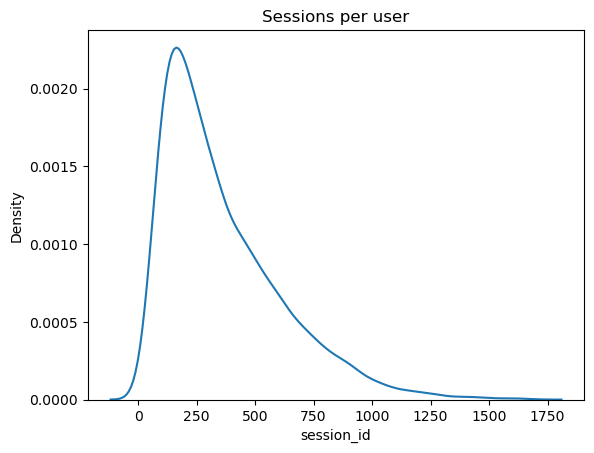

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(tmp.groupby("uid")["session_id"].nunique())
plt.title("Sessions per user")
plt.show()

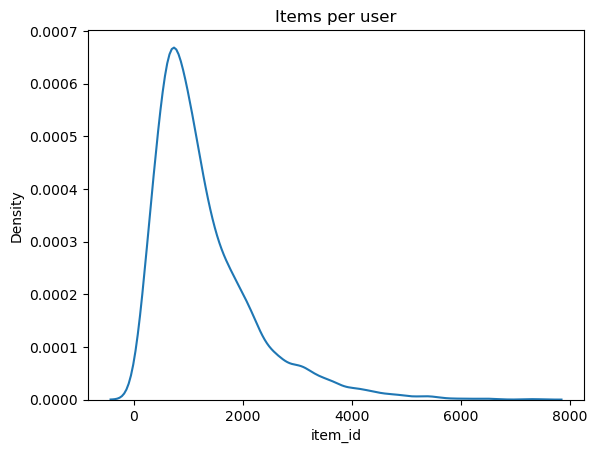

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(tmp.groupby("uid")["item_id"].nunique())
plt.title("Items per user")
plt.show()